# Semantic Segmentation on Google images


---



## WORKFLOW


- Analyze data - Exploratory Data Analysis (EDA)
  - Regression of Classification?
  - What is the target variable?
  - Is the data unbalanced?
  -  What are the features? Correlation, ranges, variances, values, NaN, errors...
  - Plot to make findings clearer
- Define the relevant metrics to be used
- Train a first baseline algorithm as a reference, e.g.:
  - For regression, train a model with all the features
  - For classification test basic models as the one-class-classifier (always the same class) and the basic
  logistic regression with all the features
  - If there is already a State of the Art solution, use it as an additional baseline
- Prepare data (where needed):
  - cleaning (e.g. remove NaN, outliers, ...)
  - normalization
  - shuffling and train, test and validation set construction
    - check the statistical properties of the splits
- Design experiments and define hyperparameters
- Repeat until performance on the test set is acceptable:
  - Train model and cross validate hyper parameters until acceptable performance on training set is
  achieved
  - Test best hyper parameter model and check if there is overfitting or underfitting
- Final Evaluation: ablation studies and failure modes

## Description

##Summary


Photovoltaic (PV) energy generation plays a crucial role in the energy transition. Small-scale, residential PV installations are deployed at an unprecedented pace, and their safe integration into the grid necessitates up-to-date, high-quality information. Overhead imagery is increasingly used to improve the knowledge of residential PV installations with machine learning models capable of automatically mapping these installations. However, these models cannot be reliably transferred from one region or imagery source to another without incurring a decrease in accuracy. To address this issue, known as distribution shift, and foster the development of PV array mapping pipelines, we propose a dataset containing aerial images, segmentation masks, and installation metadata. We provide installation metadata for more than 28000 installations. We provide ground truth segmentation masks for 13000 installations, including 7000 with annotations for two different image providers. Finally, we provide installation metadata that matches the annotation for more than 8000 installations. Dataset applications include end-to-end PV registry construction, robust PV installations mapping, and analysis of crowdsourced datasets.

This dataset contains the complete records associated with the article "A crowdsourced dataset of aerial images of solar panels, their segmentation masks, and characteristics", published in Scientific data. The article is accessible here : https://www.nature.com/articles/s41597-023-01951-4

These complete records consist of:

1. The complete training dataset containing RGB overhead imagery, segmentation masks and metadata of PV installations (folder bdappv),
2. The raw crowdsourcing data, and the postprocessed data for replication and validation (folder data).
---
The description above is copied from the official page of the dataset.

The dataset can be found here: https://zenodo.org/records/7358126

The paper can be found here: https://www.nature.com/articles/s41597-023-01951-4

# About the dataset

---



### bdappv/ Root data folder



- google/ign:  One folder for each campaign
  - img/: Folder containing all the images presented to the users. This folder contains 28807 images for Google and 17325 images for IGN.
  - mask/: Folder containing all segmentations masks generated from the polygon annotations of the users. This folder contains 13303 masks for Google and 7686 masks for IGN.
- metadata.csv The .csv  file with the installations' metadata.


### data/ Root data folder

- raw/ Folder containing the raw crowdsourcing data and raw metadata;
  - input-google.json: .json input data data containing all information on images and raw annotators’ contributions for both phases (clicks and polygons) during the first annotation campaign;
  - input-ign.json: .json input data containing all information on images and raw annotators’ contributions for both phases (clicks and polygons) during the second annotation campaign;
  - raw-metadata.json: .json output containing the PV systems’ metadata extracted from the BDPV database before filtering. It can be used to replicate the association between the installations and the segmentation masks, as done in the notebook metadata.
- replication/ Folder containing the compiled data used to generate the segmentation masks;
  - campaign-google/campaign-ign: One folder for each campaign
    - click-analysis.json: .json output on the click analysis, compiling raw input into a few best-guess locations for the PV arrays. This dataset enables the replication of our annotations,
    - polygon-analysis.json: .json output of polygon analysis, compiling raw input into a best-guess polygon for the PV arrays.
- validation/ Folder containing the compiled data used for technical validation.
  - campaign-google/campaign-ign: One folder for each campaign
    - click-analysis-thres=1.0.json: .json output of the click analysis with a lowered threshold to analyze the effect of the threshold on image classification, as done in the notebook annotation;
    - polygon-analysis-thres=1.0.json: .json output of polygon analysis, with a lowered threshold to analyze the effect of the threshold on polygon annotation, as done in the notebook annotations.
  - metadata.csv: the .csv file of filtered installations' metadata.

# Import libraries & mounting Drive

---



### Mounting Drive

In [17]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### Import libraries

In [18]:
# Plotting
%matplotlib inline
%reload_ext tensorboard
import seaborn as sns
import matplotlib.pyplot as plt

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, ConcatDataset, TensorDataset, random_split
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter

# Utilites
import zipfile
import os
import requests
import shutil
import numpy as np
import pandas as pd
import sklearn
import random
from PIL import Image

from shutil import copyfile
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.5
    import pytorch_lightning as pl

from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from pytorch_lightning import Trainer

# Wget
try:
    import wget
except ModuleNotFoundError: # Google Colab does not have wget installed by default. Hence, we do it here if necessary
    !pip install wget
    import wget

## Constant values

In [19]:
CAMPAIGN = "/google"

# Loading the dataset

---



TODO: insert description of the section

## Dowload and extract

TODO: insert description

In [20]:
# URLS where you can find the dataset
BDAPPV_URL = 'https://zenodo.org/records/7358126/files/bdappv.zip?download=1'
DATA_URL = 'https://zenodo.org/records/7358126/files/data.zip?download=1'

URLS = [DATA_URL, BDAPPV_URL]

# Change this to save and extract files in different directories
SAVE_DIR = '/content/drive/MyDrive/LabIAGI_1950722/google_semantic_segmentation/dataset'
EXTRACT_DIR = '/content/drive/MyDrive/LabIAGI_1950722/google_semantic_segmentation/dataset'

TODO: insert description

In [21]:
parent_dir = '/content/drive/MyDrive/LabIAGI_1950722/google_semantic_segmentation'

# Check if the parent directory exists, if not create it
if not os.path.exists(parent_dir):
    os.makedirs(parent_dir)

# Copy the current notebook to the parent directory
current_notebook = "google_semantic_segmentation_1950722.ipynb"
destination_notebook = os.path.join(parent_dir, current_notebook)

# Check if the notebook already exists in the parent directory, if not, copy it
if not os.path.exists(destination_notebook):
    copyfile(current_notebook, destination_notebook)

# Define the path for the dataset directory
dataset_dir = os.path.join(parent_dir, "dataset")

# Check if the dataset directory exists, if not create it
if not os.path.exists(dataset_dir):
    os.makedirs(dataset_dir)

TODO: insert description

In [22]:
def download_and_extract(url, save_dir, extract_dir):
    # Get the filename from the URL
    filename = url.split('/')[-1]

    # Check if the file already exists
    if not os.path.exists(os.path.join(save_dir, filename)):
        # Download the zip file
        with requests.get(url, stream=True) as r:
            with open(os.path.join(save_dir, filename), 'wb') as f:
                shutil.copyfileobj(r.raw, f)

        # Extract the zip file
        with zipfile.ZipFile(os.path.join(save_dir, filename), 'r') as zip_ref:
            zip_ref.extractall(extract_dir)

        # Delete the zip file
        os.remove(os.path.join(save_dir, filename))
    else:
        print(f"Skipping installation of {filename}. File already exists.")


# Download and extract data from each URL
# Change this to True to download the dataset
want_to_download = False
if want_to_download:
    print("Downloading the dataset...")
    for url in URLS:
        download_and_extract(url, SAVE_DIR, EXTRACT_DIR)
else:
  print(f"To download the dataset, change the variable want_to_download, now setted to {want_to_download}")

To download the dataset, change the variable want_to_download, now setted to False


## Checking files in each directory

The following code count every file in every subdirectory of the given directory (in this case, where we extract the data).
Check the number of files yourself:
- dataset: 0
    - dataset/data: 0
        - dataset/data/raw: 3
        - dataset/data/replication: 0
            - dataset/data/replication/campaign-google: 2
            - dataset/data/replication/campaign-ign: 2
        - dataset/data/validation: 1
            - dataset/data/validation/campaign-google: 2
            - dataset/data/validation/campaign-ign: 2
    - dataset/bdappv: 2
        - dataset/bdappv/google: 0
            - dataset/bdappv/google/img: 28807
            - dataset/bdappv/google/mask: 13303
        - dataset/bdappv/ign: 0
            - dataset/bdappv/ign/img: 17325
            - dataset/bdappv/ign/mask: 7685


In [23]:
# Function to explore directories and count files
def explore_directories(directory):
    for root, dirs, files in os.walk(directory):
        print(f"Directory: {root}")
        print(f"Number of files: {len(files)}")
        print("-------------------------------------")

# Explore directories and count files
explore_directories(EXTRACT_DIR)

Directory: /content/drive/MyDrive/LabIAGI_1950722/google_semantic_segmentation/dataset
Number of files: 0
-------------------------------------
Directory: /content/drive/MyDrive/LabIAGI_1950722/google_semantic_segmentation/dataset/data
Number of files: 0
-------------------------------------
Directory: /content/drive/MyDrive/LabIAGI_1950722/google_semantic_segmentation/dataset/data/raw
Number of files: 3
-------------------------------------
Directory: /content/drive/MyDrive/LabIAGI_1950722/google_semantic_segmentation/dataset/data/replication
Number of files: 0
-------------------------------------
Directory: /content/drive/MyDrive/LabIAGI_1950722/google_semantic_segmentation/dataset/data/replication/campaign-google
Number of files: 2
-------------------------------------
Directory: /content/drive/MyDrive/LabIAGI_1950722/google_semantic_segmentation/dataset/data/replication/campaign-ign
Number of files: 2
-------------------------------------
Directory: /content/drive/MyDrive/LabIAGI_

# Exploratory Data Analysis

---



TODO: insert description of the section

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/LabIAGI_1950722/google_semantic_segmentation/dataset/bdappv/metadata.csv')

## section

TODO: inserti description

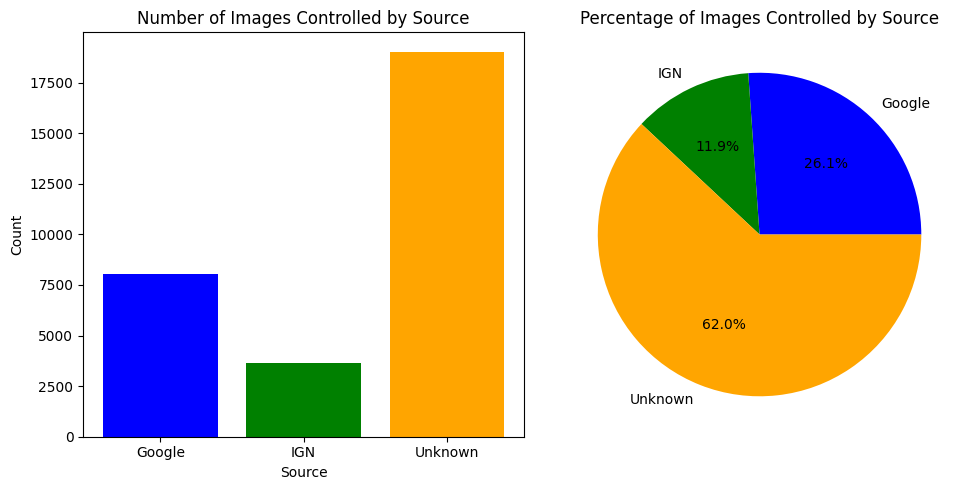

In [ ]:
google_count = (df['GoogleControlled'] == True).sum()
ign_count = (df['IGNControlled'] == True).sum()
unknown_count = ((df['GoogleControlled'] == False) & (df['IGNControlled'] == False)).sum()

# Create bar plot
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(['Google', 'IGN', 'Unknown'], [google_count, ign_count, unknown_count], color=['blue', 'green', 'orange'])
plt.xlabel('Source')
plt.ylabel('Count')
plt.title('Number of Images Controlled by Source')

# Create pie chart
plt.subplot(1, 2, 2)
labels = ['Google', 'IGN', 'Unknown']
sizes = [google_count, ign_count, unknown_count]
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=['blue', 'green', 'orange'])
plt.title('Percentage of Images Controlled by Source')

plt.tight_layout()
plt.show()

## Plot some samples

TODO: fix this basend on the constat value in the beginning


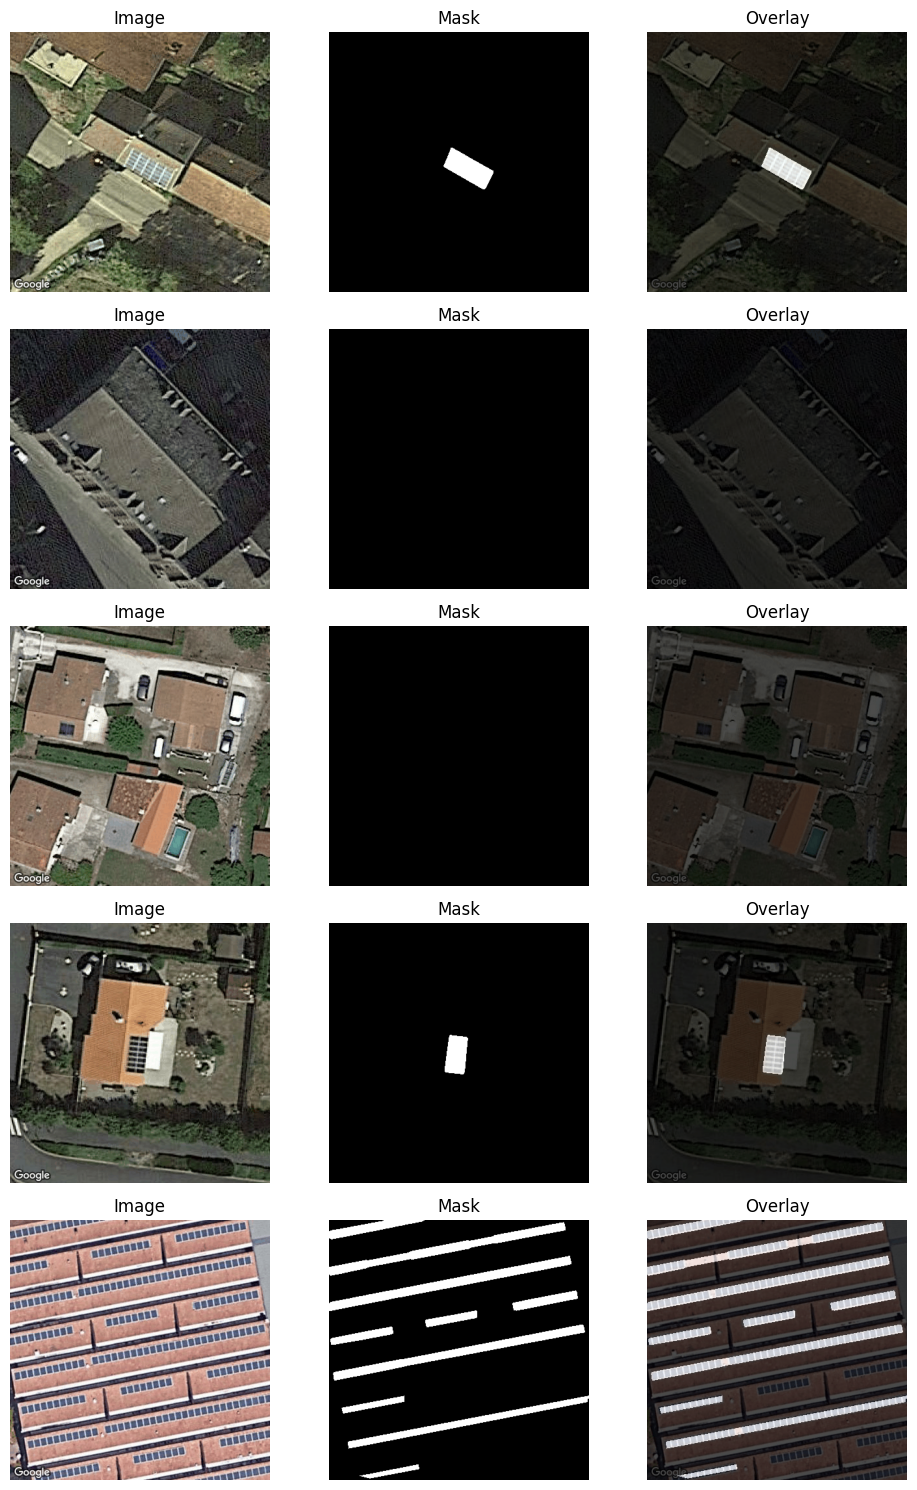

In [29]:
IMG_DIR = '/content/drive/MyDrive/LabIAGI_1950722/google_semantic_segmentation/dataset/bdappv/google/img'
MASK_DIR = '/content/drive/MyDrive/LabIAGI_1950722/google_semantic_segmentation/dataset/bdappv/google/mask'

img_files = [file for file in os.listdir(IMG_DIR) if file.endswith(('jpg', 'jpeg', 'png', 'bmp'))]
random_image_files = random.sample(img_files, 5)

plt.figure(figsize=(10, 15))
for i, random_image_file in enumerate(random_image_files, 1):
    # Get the image
    img_path = os.path.join(IMG_DIR, random_image_file)
    img = Image.open(img_path).convert('RGBA')

    # Get the mask (or a black image)
    mask_path = os.path.join(MASK_DIR, random_image_file)
    if os.path.exists(mask_path):
        mask = Image.open(mask_path)
    else:
        mask = Image.new('RGB', img.size, color='black')
    mask = mask.convert('RGBA')

    # Create an overlay
    overlay = Image.blend(img, mask, alpha=0.7)

    # Set the position of each image
    plt.subplot(5, 3, 3*i-2)
    plt.imshow(img)
    plt.title('Image')
    plt.axis('off')

    plt.subplot(5, 3, 3*i-1)
    plt.imshow(mask)
    plt.title('Mask')
    plt.axis('off')

    plt.subplot(5, 3, 3*i)
    plt.imshow(overlay)
    plt.title('Overlay')
    plt.axis('off')

plt.tight_layout()
plt.show()

# Processing the dataset
---



TODO: insert description

## Filtering by campaign

In [28]:
google_df = df[df['GoogleControlled'] == True]
google_df.drop(['IGNControlled', 'controlled'])
google_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8019 entries, 5 to 27375
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   idInstallation    8019 non-null   int64  
 1   identifiant       8019 non-null   object 
 2   idInverter        8019 non-null   int64  
 3   nameInverter      8019 non-null   object 
 4   countInverters    8019 non-null   int64  
 5   idArrays          8019 non-null   int64  
 6   nameArrays        8019 non-null   object 
 7   countArrays       8019 non-null   int64  
 8   surface           8019 non-null   float64
 9   azimuth           8019 non-null   float64
 10  typeInstallation  8019 non-null   int64  
 11  tilt              8019 non-null   int64  
 12  kWp               8019 non-null   float64
 13  departement       8019 non-null   int64  
 14  city              8017 non-null   object 
 15  selfConsumption   8019 non-null   bool   
 16  isIntegrated      8019 non-null   bool   

In [45]:
small_images = []
images_without_masks = []

for image_file in os.listdir(IMG_DIR):
    image_path = os.path.join(IMG_DIR, image_file)
    mask_path = os.path.join(MASK_DIR, image_file)

    # Check if image size is less than 10kb (10240 bytes)
    if os.path.isfile(image_path) and os.path.getsize(image_path) < 10240:
        small_images.append(image_file)

    # Check if mask exists
    if not os.path.isfile(mask_path):
        images_without_masks.append(image_file)

print(f"Image size less than 10kb: {len(small_images)}")
print(f"Image without masks: {len(images_without_masks)}")

Image size less than 10kb: 177
Image without masks: 15504


## Filtering size

TODO: insert description

# The model: U-Net

---



TODO: insert description of the section

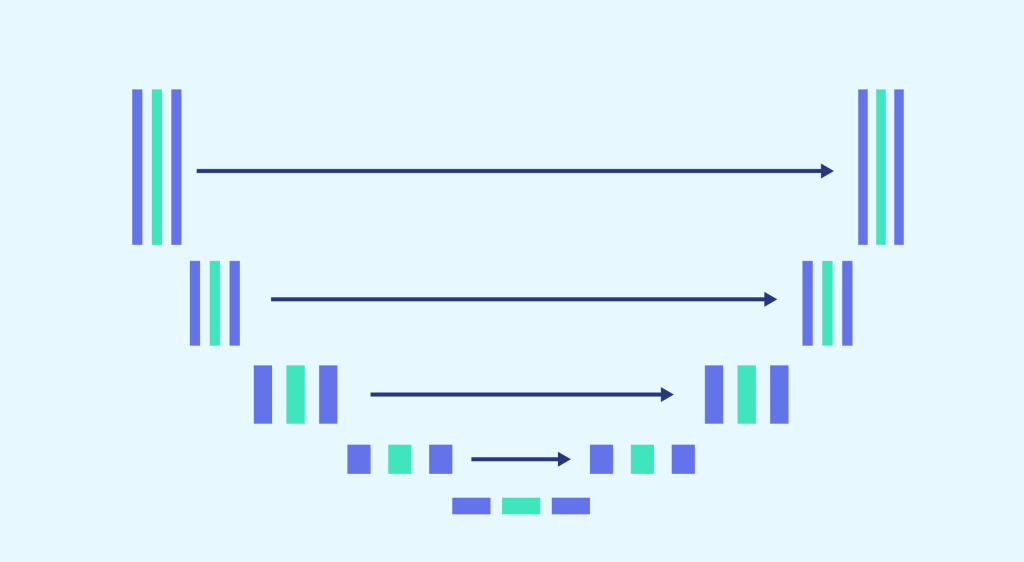

## section

TODO: inserti description

## section

TODO: inserti description

In [ ]:
"""
Come modello puoi usare una semplice U-net (o altro modello a tua scelta).
Un buon tutorial per implementare UNET è il seguente:
https://www.youtube.com/watch?v=IHq1t7NxS8k&ab_channel=AladdinPersson.

Come loss puoi usare ad esempio CrossEntropyLoss, come optimizer Adam o SGD, e
come scheduler ad esempio un semplice StepLR.
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=NUMERO DI EPOCHE CHE SETTERAI IN UNA VARIABILE//3+1)
In questo modo il learning rate viene moltiplicato di default
per 0.1 dopo un terzo delle epoche e di novo a due terzi del training e
aiuta a convergere su un risultato migliore, permettendo anche di usare un
learning rate iniziale maggiore.

Per migliorare la riproducibilità, setta il seed prima di allenare la rete:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
"""

# Dump



Come modello puoi usare una semplice U-net (o altro modello a tua scelta). Un buon tutorial per implementare UNET è il seguente: https://www.youtube.com/watch?v=IHq1t7NxS8k&ab_channel=AladdinPersson.

Come loss puoi usare ad esempio CrossEntropyLoss, come optimizer Adam o SGD, e come scheduler ad esempio un semplice StepLR.
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=NUMERO DI EPOCHE CHE SETTERAI IN UNA VARIABILE//3+1)
In questo modo il learning rate viene moltiplicato di default per 0.1 dopo un terzo delle epoche e di novo a due terzi del training e aiuta a convergere su un risultato migliore, permettendo anche di usare un learning rate iniziale maggiore.

Per migliorare la riproducibilità, setta il seed prima di allenare la rete:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

I training che dovrai eseguire sono almeno i seguenti:
- Baseline (prova diversi learning rate su scala logaritmica, una volta individuato il migliore passa al punto successivo)
- Aggiunta di data augmentation (almeno random horizontal/vertical flip, rotazioni di 0/90/180/270 gradi)
- Per questo dataset è importante provare anche ad aggiungere RandomCrop. Questo perché i pannelli solari, se sono presenti, sono quasi sempre al centro dell'immagine, e potrebbe non generalizzare bene a un caso reale.

Salvati tutti i training / pesi / grafici che fai, li vorrò vedere all'esame per vedere il lavoro fatto e le considerazioni che hai fatto.

I modelli migliori (sul validation) usali sul test set e segnati i risultati in una tabela (IoU per ogni classe, mIoU e overall accuracy).

Creati una repository GitHub dove puoi caricare di volta in volta il codice aggiornato. (Utile anche per dimostrare che il lavoro fatto è originale)

# section

---



TODO: insert description of the section

## section

TODO: inserti description

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/LabIAGI_1950722/google_semantic_segmentation/dataset/bdappv/metadata.csv')

In [ ]:
df.dtypes

# section

---



TODO: insert description of the section

## section

TODO: inserti description

In [ ]:
df.dtypes